### Preparing the Enviroment

In [1]:
# Install all necessary libraries in case they don't already exist in our enviroment
!pip3 install kaggle
!pip3 install lightgbm
!pip3 install psycopg2==2.7.6
!pip3 install mlflow

# Update Linux Sources in case we need to Install stuff
!apt-get update
!apt-get install unzip
!apt-get install libgomp1 # Fix por LightGBM

## Be ready to parse Kaggle Competition Results later on

def parse_kaggle_submissions(submits):
    '''
    After having captured results from -> !kaggle competitions submissions
    into a variable named "submits" parse them and return them as a DataFrame
    '''
    headers = list(filter(None, submits[0].split(" ")))
    data = pd.DataFrame(columns=headers)
    for x in submits[2:]:
        #parse items by order
        items = list(filter(None, x.split(" ")))
        filename = items[0]
        date = items[1] + ' ' + items[2]
        description = items[3]
        status = items[4]
        publicScore = items[5]
        privateScore = items[6]
        row = [filename,date,description,status,publicScore,privateScore]
        data.loc[len(data)] = row
    return data


Hit:1 http://security.debian.org/debian-security buster/updates InRelease
Hit:2 http://deb.debian.org/debian buster InRelease                  
Hit:3 http://deb.debian.org/debian buster-updates InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-23+deb10u2).
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgomp1 is already the newest version (8.3.0-6).


0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


### Libraries to Import

In [2]:
import os
import os.path
import kaggle
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
import numpy as np
import matplotlib.pyplot as plt
import mlflow

### Definitions for the Experiment/Run

In [3]:
#Define Competition
competition = 'santander-customer-satisfaction'

# Define Experiment
Experiment_Name = 'Experiment_2'
algorithm = 'LogisticRegressionCV'
metric = 'liblinear'

# Define Run Name
run_name = Experiment_Name + "_" + algorithm + '_with_metric_' + metric

### Get the Data

In [4]:
# To interact with Kaggle's API you need a valid token in the form of a JSON file
# This can be generated logged to Kaggle's site and download it
# For this example we are using a 

# First retrieve Token for my personal account
# This requires having an API Token and you need to create one for your accounts
# Details for that are found here: https://www.kaggle.com/docs/api
# For this one we are using a json token from my personal account stored in a public Github Repo

json_location = 'https://raw.githubusercontent.com/fermasia/infovis/gh-pages/kaggle.json'

if os.path.isfile('/root/.kaggle/kaggle.json'):
    print ("File already exists, no need to download it again")
else: 
    os.system('wget %s -P /root/.kaggle'%json_location)
    !chmod 600 /root/.kaggle/kaggle.json #adjust permissions 

# Download competition data and unzip it to local folder
!kaggle competitions download -c santander-customer-satisfaction --force
!unzip -o santander-customer-satisfaction

File already exists, no need to download it again
100%|██████████████████████████████████████| 8.25M/8.25M [00:00<00:00, 12.1MB/s]
100%|██████████████████████████████████████| 8.25M/8.25M [00:00<00:00, 10.8MB/s]
Archive:  santander-customer-satisfaction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


### Get to the Experiment Itself

In [5]:
# load Datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

# Prepare our train and test splits
# We're using a 80/20 proportion
test_size = 0.2
df = train
df.drop(['ID'], axis=1,inplace=True) # Delete Id Column
y = df.TARGET
x = df.loc[:,df.columns != 'TARGET']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

# Start Run and Track it
with mlflow.start_run(run_name=run_name):
    # check classification scores of logistic regression
    model = LogisticRegressionCV(Cs=2,
                        solver=metric,
                        max_iter=10000,
                        cv=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_predtrain = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    [fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
       
    # Logging params and metrics to MLFlow
    mlflow.log_param('algorythm',algorithm)
    mlflow.log_metric('accuracy_test', accuracy_score(y_test, y_pred))
    mlflow.log_metric('accuracy_train', accuracy_score(y_train, y_predtrain))
    
# Logging model to MLFlow
    mlflow.sklearn.log_model(model, 'model')

2021/11/27 22:31:25 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



### Get Some Provisional Result Analysis

Train/Test split results:
LogisticRegressionCV accuracy is 0.959
LogisticRegressionCV log_loss is 0.196
LogisticRegressionCV auc is 0.609


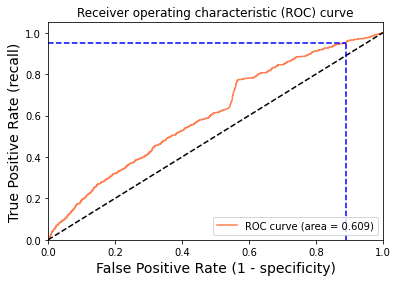

Using a threshold of 0.002 guarantees a sensitivity of 0.950 and a specificity of 0.111, i.e. a false positive rate of 88.93%.


In [6]:
print('Train/Test split results:')
print(model.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(model.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(model.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

### Submit Predictions

In [7]:
# Predict and prepare for submitting
ids = pd.DataFrame(test['ID'])
test_df = test.drop(['ID'], axis=1)
predictions = pd.DataFrame(model.predict(test_df))
final = ids.join(predictions).rename(columns={0: 'TARGET'})
final.to_csv('submission.csv',header=["ID", "TARGET"], index=False)

#Submit a prediction to Kaggle
import os
os.system("kaggle competitions submit -c santander-customer-satisfaction -f submission.csv -m '{0}'".format(run_name))

# Retrieve Submissions and Show Last Result
submits = !kaggle competitions submissions -c santander-customer-satisfaction
time.sleep(10)
print("Last Submission Retrieved:")
parse_kaggle_submissions(submits)[:1]

Last Submission Retrieved:


,fileName,date,description,status,publicScore,privateScore
0,submission.csv,2021-11-27 22:35:15,Experiment_2_LogisticRegressionCV_with_metric_...,complete,0.50000,0.49998


### The chunk of code below should be at the end of any experiment to be run
#### (We are storing all results to PostGres to be summarized later on)

In [8]:
# Create Dataframe retrieving all Runs
mlflow_runs = mlflow.search_runs('0')
mlflow_runs['duration'] = mlflow_runs.end_time - mlflow_runs.start_time # calculate run duration
mlflow_runs['duration'] = round(mlflow_runs.duration.astype('timedelta64[s]')/60,2) # Convert to minutes

#Get submission data
submits = !kaggle competitions submissions -c santander-customer-satisfaction
kaggle_runs = parse_kaggle_submissions(submits)

# Agregar nombre del Experimento
kaggle_runs = kaggle_runs.assign(Experiment=Experiment_Name)

# Correct Data Types
import numpy as np
kaggle_runs.publicScore = kaggle_runs.publicScore.replace('None',np.nan)  # Reemplazando None por NaN
kaggle_runs.publicScore = pd.to_numeric(kaggle_runs.publicScore)
kaggle_runs.privateScore = kaggle_runs.privateScore.replace('None',np.nan)  # Reemplazando None por NaN
kaggle_runs.privateScore = pd.to_numeric(kaggle_runs.privateScore)
kaggle_runs.date = pd.to_datetime(kaggle_runs.date)

# Create Connection to DataBase
from sqlalchemy import create_engine
user = "workshop"
password = "w0rkzh0p"
host = "postgres"
port = "5432"
database = "workshop"
schema = "workshop"
engine = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{database}")
connection = engine.connect()

# UPSERT KAGGLE NEW RESULTS to PostGreSQL

if engine.dialect.has_table(connection, 'kaggle_runs'):   #check if table exists
    table = pd.read_sql_table('kaggle_runs', engine) 
    merged = pd.concat([kaggle_runs[~kaggle_runs.date.isin(table.date)], table])
    merged.to_sql('kaggle_runs', con=engine, if_exists='replace',method='multi', index=False)
else:
    kaggle_runs.to_sql('kaggle_runs', con=engine, if_exists='replace',method='multi', index=False)
    
# UPSERT MLFLOW RUNS to PostGreSQL

if engine.dialect.has_table(engine.connect(), 'mlflow_runs'):   #check if table exists
    table2 = pd.read_sql_table('mlflow_runs', engine) 
    merged2 = pd.concat([mlflow_runs[~mlflow_runs.run_id.isin(table2.run_id)], table2])
    merged2.to_sql('mlflow_runs', con=engine, if_exists='replace',method='multi', index=False)
else:
    mlflow_runs.to_sql('mlflow_runs', con=engine, if_exists='replace',method='multi', index=False)

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [11]:
mlflow.search_runs('0')

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy_test,metrics.accuracy_train,params.algorythm,params.metric_type,params.algorythim,tags.mlflow.source.name,tags.mlflow.log-model.history,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.runName
0,386b232555cd421ab2313915ba5bf6ff,0,FINISHED,file:///notebook/mlruns/0/386b232555cd421ab231...,2021-11-27 22:57:47.136000+00:00,2021-11-27 22:58:33.659000+00:00,0.959616,0.961803,LGBMClassifier,binary_logloss,None,/usr/local/lib/python3.7/dist-packages/ipykern...,"[{""run_id"": ""386b232555cd421ab2313915ba5bf6ff""...",LOCAL,root,Experiment_1_LGBMClassifier_with_metric_binary...
1,7ec1716af5054eaab06bf46e916942af,0,FINISHED,file:///notebook/mlruns/0/7ec1716af5054eaab06b...,2021-11-27 22:31:25.335000+00:00,2021-11-27 22:35:12.045000+00:00,0.959155,0.960750,LogisticRegressionCV,None,None,/usr/local/lib/python3.7/dist-packages/ipykern...,"[{""run_id"": ""7ec1716af5054eaab06bf46e916942af""...",LOCAL,root,Experiment_2_LogisticRegressionCV_with_metric_...
2,33826502e3d74528b9eadb787aaa17ab,0,RUNNING,file:///notebook/mlruns/0/33826502e3d74528b9ea...,2021-11-27 22:03:51.459000+00:00,NaT,NaN,NaN,None,None,None,/usr/local/lib/python3.7/dist-packages/ipykern...,None,LOCAL,root,Experiment_2_LogisticRegressionCV_with_metric_...
3,73b7225a1d4e448c9927f785749d5665,0,FINISHED,file:///notebook/mlruns/0/73b7225a1d4e448c9927...,2021-11-27 21:57:24.537000+00:00,2021-11-27 21:57:57.745000+00:00,0.959550,0.960652,LogisticRegressionCV,None,None,/usr/local/lib/python3.7/dist-packages/ipykern...,"[{""run_id"": ""73b7225a1d4e448c9927f785749d5665""...",LOCAL,root,Experiment_2_LogisticRegressionCV_with_metric_...
4,86cb7634e1984dafa7539f17f49ed9fd,0,FAILED,file:///notebook/mlruns/0/86cb7634e1984dafa753...,2021-11-27 21:41:47.187000+00:00,2021-11-27 21:42:23.109000+00:00,NaN,NaN,None,None,None,/usr/local/lib/python3.7/dist-packages/ipykern...,None,LOCAL,root,Experiment_2_LogisticRegressionCV_with_metric_...
5,1a7b38c910554b05bce6b7145d04c156,0,FAILED,file:///notebook/mlruns/0/1a7b38c910554b05bce6...,2021-11-27 21:40:22.394000+00:00,2021-11-27 21:41:39.990000+00:00,NaN,NaN,None,None,None,/usr/local/lib/python3.7/dist-packages/ipykern...,None,LOCAL,root,Experiment_2_LogisticRegressionCV_with_metric_...
6,36855a54519641e7bc0b85cca7f3e898,0,RUNNING,file:///notebook/mlruns/0/36855a54519641e7bc0b...,2021-11-27 20:58:46.912000+00:00,NaT,NaN,NaN,None,None,None,/usr/local/lib/python3.7/dist-packages/ipykern...,None,LOCAL,root,Experiment_2_LogisticRegressionCV_with_metric_...
7,ee1efe614edf4c489d2e711ca95d665b,0,FINISHED,file:///notebook/mlruns/0/ee1efe614edf4c489d2e...,2021-11-27 20:55:48.642000+00:00,2021-11-27 20:56:33.543000+00:00,NaN,NaN,None,None,None,/usr/local/lib/python3.7/dist-packages/ipykern...,None,LOCAL,root,Experiment_2_LogisticRegression()_with_metric_...
8,6fa62057d4fe4b349cfabd05ff2b4f49,0,FAILED,file:///notebook/mlruns/0/6fa62057d4fe4b349cfa...,2021-11-27 20:55:35.506000+00:00,2021-11-27 20:55:35.513000+00:00,NaN,NaN,None,None,None,/usr/local/lib/python3.7/dist-packages/ipykern...,None,LOCAL,root,Experiment_2_LogisticRegression()_with_metric_...
9,7622e7561d4749f0b7cf5498cf88bebd,0,FINISHED,file:///notebook/mlruns/0/7622e7561d4749f0b7cf...,2021-11-27 20:52:55.760000+00:00,2021-11-27 20:53:07.700000+00:00,0.959747,0.960602,LogisticRegression(),None,None,/usr/local/lib/python3.7/dist-packages/ipykern...,"[{""run_id"": ""7622e7561d4749f0b7cf5498cf88bebd""...",LOCAL,root,Experiment_2_LogisticRegression()_with_metric_...
